# NEURAL NETWORK TO ESTIMATE HUBBLE DIAGRAM


This neural network is designed to predict the Hubble diagram using Type Ia Supernovae data from the Dark Energy Survey (DES), selected based on criteria from Toy (2024), where the probability of being a Supernova Ia is greater than 0.5.

The Hubble diagram illustrates the relationship between the distance modulus and redshift. Specifically, it plots the distance modulus (μ) as a function of redshift (z), as shown in the example below:

<img src="HR.jpeg" alt="Example Image" width="600">

In this neural network, we use the first 20 data points to train the model. The goal is to predict the relationship between distance modulus (μ) and redshift, with redshift (z) as the input and distance modulus (μ) as the output. 
There should be relation between these parameter:

$\mu = m*z$


The dataset provide redshift value and distance modulus. Before training the neural network, we will first load the dataset. These processed data will then be used for training the model to predict the relationship between redshift and distance modulus.

In [1231]:
# Importing the package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1232]:
# Load the data
fitres_file = 'BBC1D_fixgamma0copy.FITRES'

# Display the first few lines of the file to understand its structure
with open(fitres_file, 'r') as file:
    lines = file.readlines()

# Reading the file
df1 = pd.read_csv(fitres_file, sep='\s+', comment='#')

### Define redshift and distance modulus from the data

In [1233]:
distance_modulus= df1['MURES']
redshift= df1['zHD']

In [1234]:
#define x and y
x= redshift.values[0:19]
y= distance_modulus.values[0:19]

#reshape the data
x=x.reshape((len(x),1))
y=y.reshape((len(y),1))

After loading and processing the dataset, we split the data into three subsets: training, validation, and test. 

In [1235]:
train_size = int(0.7 * len(x))
valid_size = int(0.3 * len(x))
test_size = len(x) - train_size - valid_size

x_train, x_valid, x_test = x[:train_size], x[train_size:train_size+valid_size], x[-test_size:]
y_train, y_valid, y_test = y[:train_size], y[train_size:train_size+valid_size], y[-test_size:]

In [1236]:
# rescale the data into [0, 1] or [-1, 1]
x_train = (x_train- np.min(x_train)) / (np.max(x_train) - np.min(x_train))
x_valid= (x_valid- np.min(x_train)) / (np.max(x_train) - np.min(x_train))
x_test = (x_test- np.min(x_train)) / (np.max(x_train) - np.min(x_train))

In [1237]:
# rescale the data into [0, 1] or [-1, 1]
shuffle_index = np.random.permutation(train_size)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]
shuffle_index = np.random.permutation(valid_size)
x_valid, y_valid = x_valid[shuffle_index], y_valid[shuffle_index]
shuffle_index = np.random.permutation(test_size)
x_test, y_test = x_test[shuffle_index], y_test[shuffle_index]

## DESIGN OF THE NEURAL NETWORK


<img src="diagram.jpeg" alt="Example Image" width="700">

The neural network consists of three layers:
- **Input Layer**: Contains 1 neuron
- **Hidden Layer**: Contains 3 neurons
- **Output Layer**: Contains 1 neuron

We use the **sigmoid activation function** in the hidden layer to introduce non-linearity.

In [1238]:
def sigmoid(x):
    '''
    sigmoid(x) = 1 / 1+exp(-x)
    '''
    return 1 / (1+np.exp(-x))

#def softmax(x):
    '''
    softmax(x) = exp(x) / ∑exp(x)
    '''
    exps = np.exp(x - np.max(x)) # this makes large exponentials numerically stable
    return exps / np.sum(exps, axis=1)[:,None]

    
def sigmoid_derivative(x):
    '''
        ∇sigmoid(x) = sigmoid(x)*(1-sigmoid(x))
    '''
    return sigmoid(x) * (1-sigmoid(x))

# let's try sigmoid
def activation(x):
    return sigmoid(x)

def activation_derivative(x):
    return sigmoid_derivative(x)

In [1239]:
# define the number of neurons in each layer first
input_layer = 1
hidden_layer = 3
output_layer = 1

In [1240]:
# initialize the weights and biases in each neuron
w1 = np.zeros([hidden_layer, input_layer])
b1 = np.zeros([hidden_layer,1])
w2 = np.zeros([output_layer, hidden_layer])
b2 = np.zeros([output_layer,1])

#we will use the initial value of weight to be 0.5 and bias to be 0.
w1 += 0.5
w2 += 0.5


## Define the gradient
Gradient of the output:
$$ \frac{\partial_L}{\partial_{y_2}} = y_2 -y$$

Gradient to the bias and weight:

$\frac{\partial_{L}}{\partial_{b_2}} = \frac{\partial_{L}}{\partial_{y_2}} \frac{\partial_{y_2}}{\partial_{z_2}} \frac{\partial_{z_2}}{\partial_{b_2}} = (y_2 -y)(1-y_2)y_2 $

$\frac{\partial_{L}}{\partial_{w_{21}}} = \frac{\partial_{L}}{\partial_{y_2}} \frac{\partial_{y_2}}{\partial_{z_2}} \frac{\partial_{z_2}}{\partial_{w_{21}}} = (y_2 -y)(1-y_2)y_2 y_{11}$

$\frac{\partial_{L}}{\partial_{w_{22}}} = \frac{\partial_{L}}{\partial_{y_2}} \frac{\partial_{y_2}}{\partial_{z_2}} \frac{\partial_{z_2}}{\partial_{w_{22}}} = (y_2 -y)(1-y_2)y_2 y_{12}$

$\frac{\partial_{L}}{\partial_{w_{23}}} = \frac{\partial_{L}}{\partial_{y_2}} \frac{\partial_{y_2}}{\partial_{z_2}} \frac{\partial_{z_2}}{\partial_{w_{23}}} = (y_2 -y)(1-y_2)y_2 y_{13}$

$\frac{\partial_{L}}{\partial_{b_{11}}} = \frac{\partial_{L}}{\partial_{y_2}} \frac{\partial_{y_2}}{\partial_{z_2}} \frac{\partial_{z_2}}{\partial_{y_{11}}} \frac{\partial_{y_{11}}}{\partial_{z_{11}}} \frac{\partial_{z_{11}}}{\partial_{b_{11}}} = (y_2 -y)(1-y_2)y_2 w_{21} (1-y_{11}) y_{11}$

$\frac{\partial_{L}}{\partial_{b_{12}}} = \frac{\partial_{L}}{\partial_{y_2}} \frac{\partial_{y_2}}{\partial_{z_2}} \frac{\partial_{z_2}}{\partial_{y_{12}}} \frac{\partial_{y_{12}}}{\partial_{z_{12}}} \frac{\partial_{z_{12}}}{\partial_{b_{12}}} = (y_2 -y)(1-y_2)y_2 w_{22} (1-y_{12}) y_{12}$

$\frac{\partial_{L}}{\partial_{b_{13}}} = \frac{\partial_{L}}{\partial_{y_2}} \frac{\partial_{y_2}}{\partial_{z_2}} \frac{\partial_{z_2}}{\partial_{y_{13}}} \frac{\partial_{y_{13}}}{\partial_{z_{13}}} \frac{\partial_{z_{13}}}{\partial_{b_{13}}} = (y_2 -y)(1-y_2)y_2 w_{23} (1-y_{13}) y_{13}$

$\frac{\partial_{L}}{\partial_{w_{11}}} = \frac{\partial_{L}}{\partial_{y_2}} \frac{\partial_{y_2}}{\partial_{z_2}} \frac{\partial_{z_2}}{\partial_{y_{11}}} \frac{\partial_{y_{11}}}{\partial_{z_{11}}} \frac{\partial_{z_{11}}}{\partial_{w_{11}}} = (y_2 -y)(1-y_2)y_2 w_{21} (1-y_{11}) y_{11} x $

$\frac{\partial_{L}}{\partial_{w_{12}}} = \frac{\partial_{L}}{\partial_{y_2}} \frac{\partial_{y_2}}{\partial_{z_2}} \frac{\partial_{z_2}}{\partial_{y_{12}}} \frac{\partial_{y_{12}}}{\partial_{z_{12}}} \frac{\partial_{z_{12}}}{\partial_{w_{12}}} = (y_2 -y)(1-y_2)y_2 w_{22} (1-y_{12}) y_{12} x $

$\frac{\partial_{L}}{\partial_{w_{13}}} = \frac{\partial_{L}}{\partial_{y_2}} \frac{\partial_{y_2}}{\partial_{z_2}} \frac{\partial_{z_2}}{\partial_{y_{13}}} \frac{\partial_{y_{13}}}{\partial_{z_{13}}} \frac{\partial_{z_{13}}}{\partial_{w_{13}}} = (y_2 -y)(1-y_2)y_2 w_{23} (1-y_{13}) y_{13} x $

In [1241]:
# defining how the neuron works
def f_z(x,w,b):
    #print(x,w,b)
    return (np.matmul(w, x.T)+b).T

def f_y1(x, w1, b1):
    z1 = f_z(x, w1, b1)
    return activation(z1)

def f_y2(y1, w2, b2):
    #print("fy2", y1,w2,b2)
    z2 = f_z(y1, w2, b2)
    #print("z2", z2)
    return z2

def feed_forward(x,w1,b1,w2,b2):
    y1 = f_y1(x, w1, b1)
    y2 = f_y2(y1, w2, b2)
    return y2

In [1242]:
def cross_entropy_loss(y, y2):
    '''
        L(y, ŷ) = ∑0.5(ŷ-y)^2.
    '''
    return np.sum(np.multiply(0.5, (y2-y)**2))/len(y)

In [1243]:
def gradient_descent(x,y,w1,b1,w2,b2):
    z1 = f_z(x, w1, b1)
    y1 = f_y1(x, w1, b1)
    y2 = f_y2(y1, w2, b2)

    dLdz2 = y2-y

    dLdw2 = np.matmul(dLdz2.T, y1) / len(y1)

    dLdb2 = np.sum(dLdz2, axis=0).reshape([-1,1]) / len(y1)

    dy1dz1 = activation_derivative(z1)

    dLdz1 = np.matmul(dLdz2, w2) * dy1dz1

    dLdw1 = np.matmul(dLdz1.T, x) / len(y1) 
    dLdb1 = np.sum(dLdz1, axis=0).reshape([-1,1]) / len(y1) 

    return {'dLdw1': dLdw1, 'dLdw2': dLdw2, 'dLdb1': dLdb1, 'dLdb2': dLdb2}

## Training the Data

First, we will use a small learning rate (learning rate = 0.1) to observe how the training progresses over 10 steps. In this case, we use **full batch training**, meaning all training data (consisting of 13 data points) will be used as input in each step of the training process.


In [1244]:
#Small learning rate
l_rate = 0.1# learning rate
Nepoch = 10  
loss_train = np.zeros(Nepoch) # we will store the loss function for the training set
loss_valid = np.zeros(Nepoch) # and validation

arrays = []

for step in range(Nepoch):
    i=step
    # calculate the loss using both training and validation sets
    output_train = feed_forward(x_train, w1, b1, w2, b2)
    loss_train[step] = cross_entropy_loss(y_train, output_train)
    output_valid = feed_forward(x_valid, w1, b1, w2, b2)
    loss_valid[step] = cross_entropy_loss(y_valid, output_valid)

    # illustrate the performance using the test set
    output_test = feed_forward(x_test, w1, b1, w2, b2)

    # calculate the gradient and update the weights
    grad = gradient_descent(x_train, y_train, w1, b1, w2, b2)
    w1 = w1 - l_rate * grad['dLdw1']
    b1 = b1 - l_rate * grad['dLdb1']
    w2 = w2 - l_rate * grad['dLdw2']
    b2 = b2 - l_rate * grad['dLdb2']
    arrays.append(np.concatenate([np.array(w1)[:, 0], np.array(b1)[:, 0], np.array(grad['dLdw1'])[:, 0], np.array(grad['dLdb1'])[:, 0],
                                  np.array(w2)[0, :], np.array(b2)[0, :], np.array(grad['dLdw2'])[0, :], np.array(grad['dLdb2'])[0, :],
                                  [loss_train[step]],[loss_valid[step]], np.array(output_train)[:, 0]]))
arrays = pd.DataFrame(arrays)
arrays.columns = ['w11', 'w12', 'w13', 'b11', 'b12', 'b13', 'dLw11', 'dLw12', 'dLw13', 'dLb11', 'dLb12', 'dLb13',
                  'w21', 'w22', 'w23', 'b2', 'dLw21', 'dLw22', 'dLw23', 'dLb2', 'Train Loss', 'Valid Loss', 'output train data 1','output train data 2','output train data 3', 'output train data 4',
                  'output train data 5', 'output train data 6', 'output train data 7', 'output train data 8', 'output train data 9', 'output train data 10', 'output train data 11',
                  'output train data 12', 'output train data 13']
pd.set_option('display.max_columns', 500)
display(arrays.head(20))
    
        

,w11,w12,w13,b11,b12,b13,dLw11,dLw12,dLw13,dLb11,dLb12,dLb13,w21,w22,w23,b2,dLw21,dLw22,dLw23,dLb2,Train Loss,Valid Loss,output train data 1,output train data 2,output train data 3,output train data 4,output train data 5,output train data 6,output train data 7,output train data 8,output train data 9,output train data 10,output train data 11,output train data 12,output train data 13
0,0.494932,0.494932,0.494932,-0.010353,-0.010353,-0.010353,0.050684,0.050684,0.050684,0.103529,0.103529,0.103529,0.452602,0.452602,0.452602,-0.084455,0.473980,0.473980,0.473980,0.844554,0.405213,0.364606,0.841351,0.809940,0.882425,0.789966,0.857123,0.913414,0.825601,0.834856,0.933689,0.798240,0.800449,0.833643,0.750000
1,0.491208,0.491208,0.491208,-0.017870,-0.017870,-0.017870,0.037240,0.037240,0.037240,0.075174,0.075174,0.075174,0.414797,0.414797,0.414797,-0.152115,0.378050,0.378050,0.378050,0.676596,0.276995,0.237712,0.672844,0.644664,0.709720,0.626754,0.687000,0.737564,0.658712,0.667015,0.755794,0.634172,0.636153,0.665927,0.590933
2,0.488426,0.488426,0.488426,-0.023406,-0.023406,-0.023406,0.027814,0.027814,0.027814,0.055357,0.055357,0.055357,0.384523,0.384523,0.384523,-0.206439,0.302743,0.302743,0.302743,0.543238,0.195304,0.158157,0.539060,0.513407,0.572647,0.497108,0.551951,0.598024,0.526194,0.533753,0.614646,0.503858,0.505661,0.532762,0.464521
3,0.486316,0.486316,0.486316,-0.027534,-0.027534,-0.027534,0.021099,0.021099,0.021099,0.041281,0.041281,0.041281,0.360207,0.360207,0.360207,-0.250122,0.243154,0.243154,0.243154,0.436836,0.142895,0.108128,0.432324,0.408665,0.463315,0.393635,0.444217,0.486739,0.420457,0.427429,0.502088,0.399860,0.401522,0.426516,0.363596
4,0.484692,0.484692,0.484692,-0.030647,-0.030647,-0.030647,0.016244,0.016244,0.016244,0.031131,0.031131,0.031131,0.340634,0.340634,0.340634,-0.285287,0.195733,0.195733,0.195733,0.351644,0.109103,0.076668,0.346870,0.324792,0.375796,0.310771,0.357969,0.397667,0.335796,0.342302,0.412002,0.316578,0.318129,0.341449,0.282751
5,0.483423,0.483423,0.483423,-0.033018,-0.033018,-0.033018,0.012684,0.012684,0.012684,0.023710,0.023710,0.023710,0.324850,0.324850,0.324850,-0.313613,0.157841,0.157841,0.157841,0.283261,0.087234,0.056942,0.278278,0.257463,0.305555,0.244246,0.288744,0.326185,0.267837,0.273971,0.339709,0.249719,0.251181,0.273167,0.217835
6,0.482419,0.482419,0.482419,-0.034839,-0.034839,-0.034839,0.010041,0.010041,0.010041,0.018213,0.018213,0.018213,0.312103,0.312103,0.312103,-0.336439,0.127471,0.127471,0.127471,0.228266,0.073043,0.044648,0.223116,0.203313,0.249072,0.190740,0.233074,0.268706,0.213182,0.219018,0.281579,0.195946,0.197337,0.218253,0.165618
7,0.481614,0.481614,0.481614,-0.036249,-0.036249,-0.036249,0.008055,0.008055,0.008055,0.014093,0.014093,0.014093,0.301795,0.301795,0.301795,-0.354837,0.103076,0.103076,0.103076,0.183976,0.063815,0.037060,0.178693,0.159703,0.203586,0.147646,0.188242,0.222419,0.169166,0.174763,0.234768,0.152639,0.153972,0.174029,0.123561
8,0.480959,0.480959,0.480959,-0.037346,-0.037346,-0.037346,0.006547,0.006547,0.006547,0.010972,0.010972,0.010972,0.293451,0.293451,0.293451,-0.369664,0.083446,0.083446,0.083446,0.148269,0.057804,0.032445,0.142878,0.124543,0.166915,0.112904,0.152099,0.185102,0.133680,0.139083,0.197029,0.117724,0.119011,0.138375,0.089652
9,0.480420,0.480420,0.480420,-0.038204,-0.038204,-0.038204,0.005391,0.005391,0.005391,0.008584,0.008584,0.008584,0.286687,0.286687,0.286687,-0.381610,0.067632,0.067632,0.067632,0.119458,0.053885,0.029699,0.113980,0.096175,0.137325,0.084872,0.122936,0.154990,0.105048,0.110295,0.166576,0.089552,0.090803,0.109607,0.062294


The listing of weights, biases, gradients, losses, and outputs at a learning rate of 0.1 are shown above. Given that the training set consists of 13 data points, we have 13 outputs for each training step. While we only list the outputs for the training data here, the losses for both the validation and training data can be seen in the plot below.


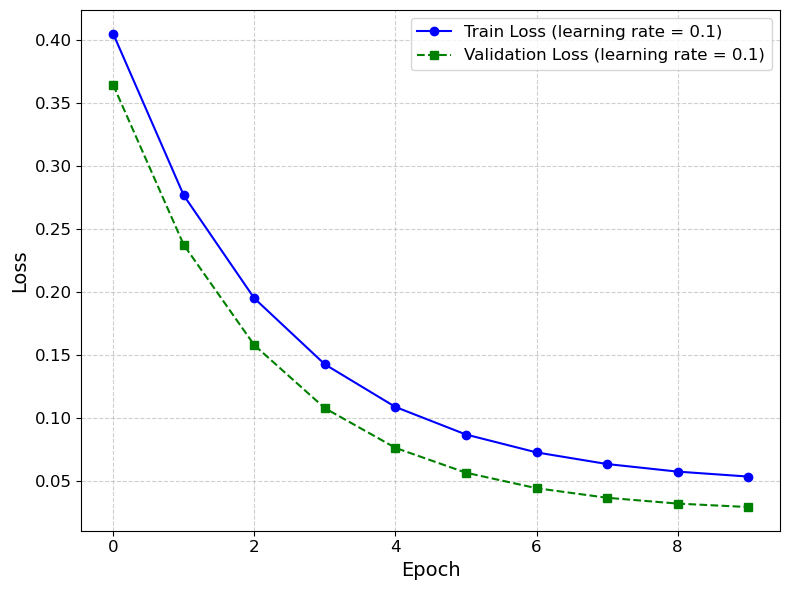

In [1245]:
# Plotting the loss
fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size for better readability
ax.plot(loss_train, label='Train Loss (learning rate = 0.1)', color='blue', linestyle='-', marker='o', markersize=6)
ax.plot(loss_valid, label='Validation Loss (learning rate = 0.1)', color='green', linestyle='--', marker='s', markersize=6)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(loc='upper right', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.tight_layout()
plt.show()


From the plot, we can observe that the loss function decreases consistently over the training steps. This indicates that the neural network is effectively learning from the training data and improving its predictions.


### Now Increase the Learning Rate to 1.1

We will use the same code as above, but this time we will set the learning rate to 1.1. This adjustment will allow us to observe how the training process and model performance change with a higher learning rate.


,w11,w12,w13,b11,b12,b13,dLw11,dLw12,dLw13,dLb11,dLb12,dLb13,w21,w22,w23,b2,dLw21,dLw22,dLw23,dLb2,Train Loss,Valid Loss,output train data 1,output train data 2,output train data 3,output train data 4,output train data 5,output train data 6,output train data 7,output train data 8,output train data 9,output train data 10,output train data 11,output train data 12,output train data 13
0,0.444247,0.444247,0.444247,-0.113882,-0.113882,-0.113882,0.050684,0.050684,0.050684,0.103529,0.103529,0.103529,-0.021378,-0.021378,-0.021378,-0.929009,0.473980,0.473980,0.473980,0.844554,0.405213,0.364606,0.841351,0.809940,0.882425,0.789966,0.857123,0.913414,0.825601,0.834856,0.933689,0.798240,0.800449,0.833643,0.750000
1,0.441739,0.441739,0.441739,-0.119462,-0.119462,-0.119462,0.002280,0.002280,0.002280,0.005073,0.005073,0.005073,0.526033,0.526033,0.526033,0.120613,-0.497646,-0.497646,-0.497646,-0.954202,0.500191,0.548900,-0.962736,-0.961532,-0.964323,-0.960770,-0.963344,-0.965530,-0.962131,-0.962487,-0.966325,-0.961085,-0.961170,-0.962440,-0.959252
2,0.374905,0.374905,0.374905,-0.256315,-0.256315,-0.256315,0.060758,0.060758,0.060758,0.124412,0.124412,0.124412,-0.022641,-0.022641,-0.022641,-0.926131,0.498795,0.498795,0.498795,0.951585,0.501068,0.456682,0.947834,0.918363,0.986676,0.899715,0.962706,1.016240,0.933034,0.941725,1.035719,0.907432,0.909494,0.940585,0.862588
3,0.372243,0.372243,0.372243,-0.262207,-0.262207,-0.262207,0.002421,0.002421,0.002421,0.005356,0.005356,0.005356,0.477317,0.477317,0.477317,0.119256,-0.454508,-0.454508,-0.454508,-0.950352,0.496533,0.544788,-0.958858,-0.957784,-0.960284,-0.957107,-0.959403,-0.961379,-0.958318,-0.958635,-0.962104,-0.957386,-0.957461,-0.958593,-0.955764
4,0.320026,0.320026,0.320026,-0.368311,-0.368311,-0.368311,0.047469,0.047469,0.047469,0.096458,0.096458,0.096458,0.048568,0.048568,0.048568,-0.773540,0.389772,0.389772,0.389772,0.811633,0.376729,0.329992,0.806629,0.784144,0.836478,0.769978,0.818027,0.859389,0.795321,0.801957,0.874584,0.775834,0.777401,0.801086,0.741900
5,0.324146,0.324146,0.324146,-0.359091,-0.359091,-0.359091,-0.003746,-0.003746,-0.003746,-0.008381,-0.008381,-0.008381,0.390459,0.390459,0.390459,-0.003207,-0.310810,-0.310810,-0.310810,-0.700302,0.290393,0.318475,-0.708367,-0.710312,-0.705775,-0.711535,-0.707378,-0.703776,-0.709346,-0.708772,-0.702446,-0.711030,-0.710894,-0.708847,-0.713954
6,0.295859,0.295859,0.295859,-0.415353,-0.415353,-0.415353,0.025716,0.025716,0.025716,0.051147,0.051147,0.051147,0.127474,0.127474,0.127474,-0.586254,0.239078,0.239078,0.239078,0.530043,0.187017,0.146519,0.523998,0.508137,0.545127,0.498166,0.532055,0.561411,0.516016,0.520699,0.572249,0.502287,0.503389,0.520084,0.478439
7,0.301964,0.301964,0.301964,-0.401190,-0.401190,-0.401190,-0.005549,-0.005549,-0.005549,-0.012876,-0.012876,-0.012876,0.322145,0.322145,0.322145,-0.131873,-0.176974,-0.176974,-0.176974,-0.413074,0.130727,0.138953,-0.420748,-0.425432,-0.414497,-0.428375,-0.418366,-0.409671,-0.423106,-0.421722,-0.406455,-0.427159,-0.426834,-0.421904,-0.434193
8,0.288328,0.288328,0.288328,-0.427082,-0.427082,-0.427082,0.012396,0.012396,0.012396,0.023538,0.023538,0.023538,0.178472,0.178472,0.178472,-0.458643,0.130611,0.130611,0.130611,0.297064,0.090254,0.058972,0.290461,0.278349,0.306615,0.270739,0.296618,0.319082,0.284364,0.287941,0.327390,0.273883,0.274725,0.287471,0.255693
9,0.292533,0.292533,0.292533,-0.416485,-0.416485,-0.416485,-0.003823,-0.003823,-0.003823,-0.009633,-0.009633,-0.009633,0.281387,0.281387,0.281387,-0.214978,-0.093559,-0.093559,-0.093559,-0.221514,0.070098,0.066410,-0.228946,-0.235324,-0.220435,-0.239330,-0.225703,-0.213861,-0.232157,-0.230273,-0.209478,-0.237674,-0.237232,-0.230521,-0.247248


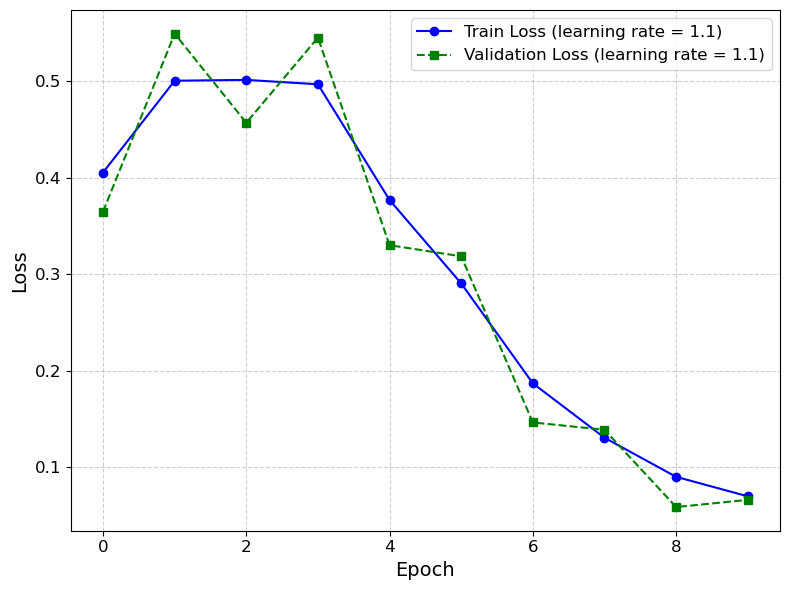

In [1246]:
#large learning rate

# reinitialize the weights and biases in each neuron
w1_large = np.zeros([hidden_layer, input_layer])
b1_large = np.zeros([hidden_layer,1])
w2_large = np.zeros([output_layer, hidden_layer])
b2_large = np.zeros([output_layer,1])

w1_large += 0.5
w2_large += 0.5


l_rate_large = 1.1 # learning rate
loss_train_large = np.zeros(Nepoch) # we will store the loss function for the training set
loss_valid_large= np.zeros(Nepoch) # and validation

arrays_large = []

for step in range(Nepoch):
    # calculate the loss using both training and validation sets
    output_train_large = feed_forward(x_train, w1_large, b1_large, w2_large, b2_large)
    loss_train_large[step] = cross_entropy_loss(y_train, output_train_large)
    output_valid_large = feed_forward(x_valid, w1_large, b1_large, w2_large, b2_large)
    loss_valid_large[step] = cross_entropy_loss(y_valid, output_valid_large)

    # illustrate the performance using the test set
    #output_test_large = feed_forward(x_test[:num_col], w1, b1, w2, b2)

    # calculate the gradient and update the weights
    grad_large= gradient_descent(x_train, y_train, w1_large, b1_large, w2_large, b2_large)
    w1_large = w1_large - l_rate_large * grad_large['dLdw1']
    b1_large = b1_large - l_rate_large * grad_large['dLdb1']
    w2_large = w2_large - l_rate_large * grad_large['dLdw2']
    b2_large = b2_large - l_rate_large * grad_large['dLdb2']
    arrays_large.append(np.concatenate([np.array(w1_large)[:, 0], np.array(b1_large)[:, 0], np.array(grad_large['dLdw1'])[:, 0], np.array(grad_large['dLdb1'])[:, 0],
                                  np.array(w2_large)[0, :], np.array(b2_large)[0, :], np.array(grad_large['dLdw2'])[0, :], np.array(grad_large['dLdb2'])[0, :],
                                  [loss_train_large[step]],[loss_valid_large[step]], np.array(output_train_large)[:, 0]]))
    # Print output
    
arrays_large = pd.DataFrame(arrays_large)
arrays_large.columns = ['w11', 'w12', 'w13', 'b11', 'b12', 'b13', 'dLw11', 'dLw12', 'dLw13', 'dLb11', 'dLb12', 'dLb13',
                  'w21', 'w22', 'w23', 'b2', 'dLw21', 'dLw22', 'dLw23', 'dLb2', 'Train Loss', 'Valid Loss', 'output train data 1','output train data 2','output train data 3', 'output train data 4',
                  'output train data 5', 'output train data 6', 'output train data 7', 'output train data 8', 'output train data 9', 'output train data 10', 'output train data 11',
                  'output train data 12', 'output train data 13']
pd.set_option('display.max_columns', 500)
display(arrays_large.head(20))
    
# Plotting the loss
fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size for better readability
ax.plot(loss_train_large, label='Train Loss (learning rate = 1.1)', color='blue', linestyle='-', marker='o', markersize=6)
ax.plot(loss_valid_large, label='Validation Loss (learning rate = 1.1)', color='green', linestyle='--', marker='s', markersize=6)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(loc='upper right', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.tight_layout()
plt.show()


From the plot, we can see that when we increase the learning rate to 1.1, the loss does not decrease consistently. This demonstrates the importance of choosing an appropriate learning rate.
